In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 1. SETUP: Synthetic Dataset Configuration
N_SAMPLES = 1000
# 20% of queries are "date-heavy" (Keyword search wins)
# 80% are "semantic" (Dense search wins)
# 0 -> semantic, 1 -> date
is_date_query = np.random.choice([0, 1], size=N_SAMPLES, p=[0.8, 0.2])

# Success Probabilities: [Dense, Keyword]
# Dense handles semantic better; Keyword handles dates better
PROB_SUCCESS = {
    0: [0.8, 0.3], # Semantic query: Dense (80%) vs Keyword (30%)
    1: [0.4, 0.9]  # Date query:     Dense (40%) vs Keyword (90%)
}

## Non contextual bandit algo

In [5]:
def run_epsilon_greedy(epsilon=0.1):
    """
    Implement epsilon-greedy policy
    """
    q_values = np.zeros(2) # Expected rewards for [Dense, Keyword]
    counts = np.zeros(2)
    selections = []
    
    for i in range(N_SAMPLES):
        # Explore vs Exploit
        if np.random.rand() < epsilon:
            action = np.random.choice([0, 1])
        else:
            action = np.argmax(q_values)
        
        # Get Reward
        reward = 1 if np.random.rand() < PROB_SUCCESS[is_date_query[i]][action] else 0
        
        # Update Estimates
        counts[action] += 1
        q_values[action] += (reward - q_values[action]) / counts[action]
        selections.append(action)
    return selections

## Contextual Linear UCB 

In [7]:
# 3. ALGORITHM: LinUCB (Contextual)
def run_lin_ucb(alpha=1.0):
    d = 2 # Dimension of context: [intercept, is_date]
    A = [np.identity(d) for _ in range(2)] # Covariance matrices
    b = [np.zeros(d) for _ in range(2)]    # Reward vectors
    selections = []
    
    for i in range(N_SAMPLES):
        context = np.array([1, is_date_query[i]]) # Context feature vector
        p = np.zeros(2)
        
        for a in range(2):
            theta = np.linalg.inv(A[a]) @ b[a]
            # UCB Formula: mean estimate + exploration bonus
            p[a] = theta @ context + alpha * np.sqrt(context @ np.linalg.inv(A[a]) @ context)
            
        action = np.argmax(p)
        reward = 1 if np.random.rand() < PROB_SUCCESS[is_date_query[i]][action] else 0
        
        # Update Online Linear Regression
        A[action] += np.outer(context, context)
        b[action] += reward * context
        selections.append(action)
    return selections

6
[False  True  True  True  True False  True  True False False  True  True
 False False  True  True False  True  True  True  True False  True  True
  True  True  True  True  True  True False  True  True  True  True  True
  True  True  True  True False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True 

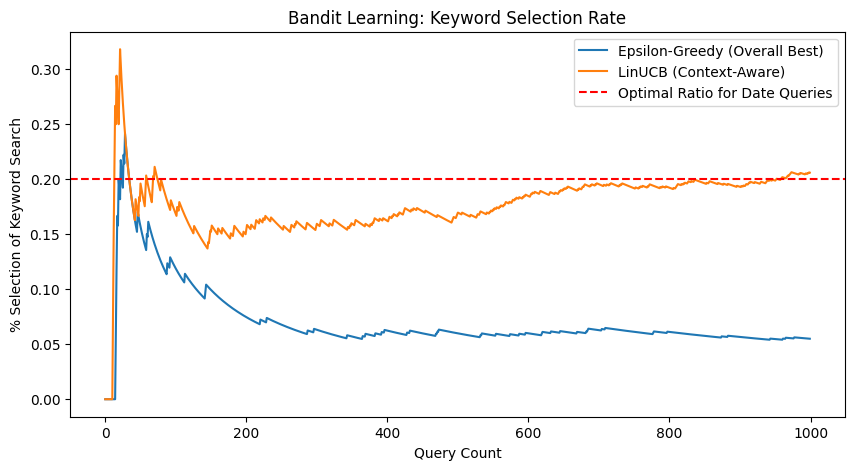

In [16]:
# Run and Plot
eg_selections = run_epsilon_greedy()
ucb_selections = run_lin_ucb()
print(eg_selections@is_date_query)
print(ucb_selections==is_date_query)
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(eg_selections) / np.arange(1, N_SAMPLES + 1), label='Epsilon-Greedy (Overall Best)')
plt.plot(np.cumsum(ucb_selections) / np.arange(1, N_SAMPLES + 1), label='LinUCB (Context-Aware)')
plt.axhline(y=0.2, color='r', linestyle='--', label='Optimal Ratio for Date Queries')
plt.title("Bandit Learning: Keyword Selection Rate")
plt.xlabel("Query Count")
plt.ylabel("% Selection of Keyword Search")
plt.legend()
plt.show()